###DINAMICA MOLECULAR DE UNA NANOPARTICULA
Cargamos las librerias

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from google.colab import drive

Definimos la ruta de los archivos

In [ ]:
drive.mount('/content/drive')
data = '/content/drive/My Drive/Colab Notebooks/Info III/DM/data/'
plots = '/content/drive/My Drive/Colab Notebooks/Info III/DM/plots/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Definición de funciones

In [ ]:
# Función de corrección de momento lineal
def momentoP_CM(v, Ntot):
  Sum = np.zeros((1, 3))
  SumR = np.zeros((1, 3))
  Sum[0, :] = sum(v[:, :]) / Ntot
  v[:, :] = v[:, :] - Sum[0, :]
  SumR[0, :] = sum(r[:, :]) / Ntot
  r[:, :] = r[:, :] - SumR[0, :]

  return v, Sum, SumR

# Función de correción de momento angular
def momentoL(r, v, Ntot, ao):
  Sumrxv = np.zeros((1, 3))
  SumR2 = 0.
  Omega = np.zeros((1, 3))

  for ii in range(0, Ntot):
    Sumrxv = Sumrxv + np.cross(r[ii, :], v[ii, :])
    SumR2 = SumR2 + r[ii, 0]**2 + r[ii, 1]**2 + r[ii, 2]**2
  Omega = Sumrxv / SumR2

  for ii in range(0, Ntot):
    v[ii, :] = v[ii, :] - np.cross(Omega[0, :], r[ii, :])
  Omega = Omega * ao

  return v, Omega

# Corrección de Velocidades por escalamiento del termostato
def Termostato(v, Ntot, Mat, KB, T):
  Sum = np.zeros((1, 3))
  SumV2 = sum(v[:, 0]**2) + sum(v[:, 1]**2) + sum(v[:, 2]**2)
  Vrms = np.sqrt(SumV2) / Ntot
  Kij = 0.5 * Mat * SumV2
  Tins = 2 * Kij / (3 * KB * Ntot)
  v[:, :] = np.sqrt(T / Tins) * v[:, :]

  return Kij, Tins, Vrms

# Función para calcular la fuerza entre átomos
def Fuerza_Energia(r, c, n, m, Epsilon, ao, Ntot, Rcut, Mat, d):

  #Calculo de Fuerza para cada particula i
  fi = np.zeros((Ntot, 3))
  rho = np.zeros((Ntot, 1))
  FUr = np.zeros((Ntot, 3))
  FRho = np.zeros((Ntot, 3))
  r2 = np.zeros((Ntot, 3))
  deltaRij = np.zeros((1, 3))
  Uij = 0

  #Calculo de densidad para cada particula i
  for ii in range(0, Ntot):
    for jj in range(0, Ntot):
      if ii != jj:
        deltaRij = r[jj, :] - r[ii, :]
        Rij = np.sqrt(sum(deltaRij ** 2))
        if Rij < Rcut:
          rho[ii, :] = rho[ii, :] + (ao/Rij)**m

  # Evaluación de la fuerza y energía
  for ii in range(0, Ntot):
    Ui = 0
    Ur = 0
    for jj in range(0, Ntot):
      if ii != jj:
        deltaRij = r[jj, :] - r[ii, :]
        Rij = np.sqrt(sum(deltaRij**2))
        if Rij < Rcut:
          Ur = Ur + (ao/Rij)**n # Calculo del potencial
          FUr[ii, :] = FUr[ii, :] + n * (ao**n) * deltaRij / (Rij**(n +2.)) # Calculo de la fuerza
          b = 1 / np.sqrt(rho[ii, 0]) + 1 / np.sqrt(rho[jj, 0])
          FRho[ii, :] = FRho[ii, :] + 0.5 * c * m * b * ((ao/Rij)**m) * deltaRij / Rij**2

      Ui = 0.5 * Ur - c * np.sqrt(rho[ii, 0])
      Uij = Uij + Ui
      fi[ii, :] = - FUr[ii, :] + FRho[ii, :]

  Uij = Uij * Epsilon
  fi = fi * Epsilon
  #print(FRho[2], FUr[2], fi[2], (ao/Rij))

  return fi, Uij, rho

# Garantizar condiciones periódica
def Pacman(r, d):
  for ii in range(0, Ntot):
    if r[ii, 0] < (-d/2.):
      r[ii, 0] = r[ii, 0] + d
    if r[ii, 0] > (+d/2.):
      r[ii, 0] = r[ii, 0] - d
    if r[ii, 1] < (-d/2.):
      r[ii, 1] = r[ii, 1] + d
    if r[ii, 1] > (+d/2.):
      r[ii, 1] = r[ii, 1] - d
    if r[ii, 2] < (-d/2.):
      r[ii, 2] = r[ii, 2] + d
    if r[ii, 2] > (+d/2.):
      r[ii, 2] = r[ii, 2] - d

    return r

###Creacion de los archivos de texto para informacion y resultados, y sus formatos

In [ ]:
InitialState = open(data + 'InitialState.dat', 'w')
Relaxation = open(data + 'Relaxation.dat' ,'w') # A una sola temperatura
EvolutionT = open(data + 'Evolution.dat', 'w') # Diferentes imágenes de la muestra
ResultsVsT = open(data + 'esultsVsT.dat', 'w')                                  #
FinalState = open(data + 'FinalState.dat', 'w')

# Llamado de subrutina "input" de parametros de entrada
input = open(data + 'input.dat', 'r')

###Parametros constantes e inicializacion de variables generales

In [ ]:
for i, linea in enumerate(input):
 if i == 3:
   Ntot = int(linea)
 if i == 5:
   d = float(linea)
 if i == 7:
   Ti = float(linea)
 if i == 9:
   Tf = float(linea)
 if i == 11:
   dT = float(linea)
 if i == 13:
   Mat = float(linea) * 1.660538e-27 # Convirtiendo de uma a kg
 if i == 15:
   ao = float(linea) * 1e-10
 if i == 17:
   Epsilon = float(linea) * 1.602176462e-19 # Trasladando eV a Joule
 if i == 19:
   Dmin = float(linea) * 1.602176462e-19 # Trasladando eV a Joule
 if i == 21:
   c = float(linea)
 if i == 23:
   n = float(linea)
 if i == 25:
   m = float(linea)
 if i == 27:
   Rcut = float(linea) * ao
 if i == 29:
   dTime = float(linea) * 1e-15
 if i == 31:
   MDSMax = int(linea)
 if i == 33:
   MDSCut = int(linea)
 if i == 35:
   twin = int(linea)
 if i == 37:
   Trlj = float(linea)
 if i == 39:
   idum = int(linea)

np.random.seed(idum)

print(Ti)

150.0


###Definición Parametros y Matrices

In [ ]:
KB = 1.3806504e-23 # En Joules
T = Ti
deltaRij = np.zeros((1, 3))
temp = np.zeros((Ntot, 3))
MRelaxation = np.zeros((MDSMax, 5))
NTras = int(abs((Ti - Tf) / dT) + 1)
NImages = int(NTras * MDSMax / twin) * Ntot
MResultsT= np.zeros((NTras, 5))
MEvolution = np.zeros((NImages, 8))

###Definición del estado inicial del sistema
Localización de las particulas

In [ ]:
r = np.zeros((Ntot, 3))
r[0] = 0.5 * (d - 2)

#print(r[1])

for i in range(1, Ntot):
    Band0 = 1
    while Band0 >= 1:
        Band0 = 0
        rp = np.random.rand(1, 3)
        rp = rp * (d - 2)
        for j in range(0, i):
            Rad = ((r[j, 0] - rp[0, 0])**2 + (r[j, 1] - rp[0, 1])**2 + (r[j, 2] - rp[0, 2])**2)**0.5
            if (Rad <= 1):
                Band0 = Band0 + 1
            #print(i, Band0)
    r[i] = rp

r= r - 0.5 * (d - 2) # Para centrar la caja
r = r * ao
d = d * ao

Eliminación del momento lineal

In [ ]:
v = np.zeros((Ntot, 3))
v = np.random.normal(v)
v, Sum, SumR = momentoP_CM(v, Ntot) # Eliminación del momentum
print('MomentoP y CM:', Sum, SumR)
v, Sum, SumR = momentoP_CM(v, Ntot) # Eliminación del momentum, confirmar
print('MomentoP y CM:', Sum, SumR)
vRaiz = np.zeros((Ntot, 1))

MomentoP y CM: [[-0.07405769 -0.10661255 -0.24462701]] [[-2.97055227e-11  1.17749526e-12 -4.05486575e-11]]
MomentoP y CM: [[ 6.66133815e-18  3.99680289e-17 -4.88498131e-17]] [[-2.06795153e-27  1.16322274e-26 -2.79173457e-26]]


Eliminación de momento angular

In [ ]:
v, Omega = momentoL(r, v, Ntot, ao) # Eliminación de momentum
print('Omega: ', Omega)
v, Omega = momentoL(r, v, Ntot, ao) # Eliminación del momentum
print('Omega: ', Omega)
#print(omega, SumR, R2, RXV, SumR2)

Omega:  [[-0.02171709 -0.04951434 -0.03561737]]
Omega:  [[-0.00559842 -0.01717893 -0.0137166 ]]


Normalización de la temperatura inicial

In [ ]:
# Normalización de la temperatura inicial
Kij, Tins, Vrms = Termostato(v, Ntot, Mat, KB, T) # Termostato isocinético
print('K: ', Kij, ' Tins: ', Tins, ' Vrms: ', Vrms)
Kij, Tins, Vrms = Termostato(v, Ntot, Mat, KB, T) # Termostato isocinético, confirmar
print('K: ', Kij, ' Tins: ', Tins, ' Vrms: ', Vrms)

K:  2.008760998033681e-23  Tins:  0.01939917590563289  Vrms:  0.22439233941576806
K:  1.5532316999999996e-19  Tins:  149.99999999999994  Vrms:  19.73158693734916


Imprimir archivo de estado inicial

In [ ]:
for i in range(1, Ntot):
    vRaiz[i, 0] = ((v[i, 0])**2 + (v[i, 1])**2 + (v[i, 2])**2)**0.5
MInitialState = np.column_stack((r/ao, v, vRaiz))
np.savetxt(data + 'InitialState.dat', MInitialState, fmt='%.4e') # Cifras decimales%.4e

Fueza inicial

In [ ]:
fi, Uij, rho = Fuerza_Energia(r, c, n, m, Epsilon, ao, Ntot, Rcut, Mat, d)

Termostato - Control NVT

In [ ]:
Kij, Tins, Vrms = Termostato(v, Ntot, Mat, KB, T) #Termostato isocinético

###Dinámica de relajación

In [ ]:
if T==Trlj:
    print('..... RELAXATION ....')
else:
    print('..... NVT DINAMIC ....')
print('Initial Temperature:', T)
print('Molecular Dynamics Steps:', MDSMax)
print('MDS/T Tins               Vrms              delta_r/ao             Uij/(Ntot*Dmin)    Kij/(Ntot*Dmin)')

# Ciclo de temperatura
NTras = 0
ContImages = 0
BanT = 0  # Bandera que indica el fin de ciclo
while BanT == 0:
  if T == Tf:
    BanT = 1
  if Ti == Trlj:
    BanT = 1

  # Variables Acumuladas para promedios estadisticos
  VrmsAcum = 0
  RadAcum = 0
  UijAcum = 0
  KAcum = 0

  # Dinamica de NVT
  MDS=0
  while MDS<MDSMax:

    # Algoritmo de Velocity Verlet
    temp = v + (0.5 * fi * dTime / Mat)
    rt = r # Para observar las fluctuaciones de distancia en la relajación
    r= r + temp * dTime
    r = Pacman(r, d)
    fi, Uij, rho = Fuerza_Energia(r, c, n, m, Epsilon, ao, Ntot, Rcut, Mat, d)
    v = temp + (0.5 * fi * dTime / Mat)
    Kij, Tins, Vrms = Termostato(v, Ntot, Mat, KB, T)
    v, Sum, SumR = momentoP_CM(v, Ntot) # Eliminación del momentum

    if Ti == Trlj:
      for i in range(0, Ntot):
        deltaRij = deltaRij + abs(rt[i, :] - r[i, :])
      Rad = ((deltaRij[0, 0])**2 + (deltaRij[0, 1])**2 + (deltaRij[0, 2])**2)**0.5
      print( MDS, Tins, Vrms, Rad/(ao*Ntot), Uij/(Ntot*Dmin), Kij/(Ntot*Dmin))
      MRelaxation[MDS] = ([Tins, Vrms, Rad/(ao * Ntot), Uij/(Ntot * Dmin), Kij/(Ntot * Dmin)])

    np.savetxt(data + 'Relaxation.dat', MRelaxation, fmt='%.4e') # Cifras decimales%.4e
    MDS = MDS + 1

    # Valores acumulados para reporte estadístico
    if MDS > MDSCut: # Para promedios estadísticos
      deltaRij = deltaRij + abs(rt[i, :] - r[i, :])
      Rad = ((deltaRij[0, 0])**2 + (deltaRij[0, 1])**2 + (deltaRij[0, 2])**2)**0.5
      VrmsAcum = VrmsAcum + Vrms
      RadAcum = RadAcum + Rad
      UijAcum = UijAcum + Uij
      KAcum = KAcum + Kij

    if MDS % twin == 0: #Module function
      print(ContImages)
      for ii in range(0, Ntot):
        MEvolution[ContImages + ii] = ([T, MDS/twin, r[ii, 0], r[ii, 1], r[ii, 2], v[ii, 0], v[ii, 1], v[ii, 2]])
      ContImages = ContImages + 1
  # Fin dinamica de NVT

  Vprom = VrmsAcum / (MDSMax - MDSCut)
  Rprom = RadAcum / ((MDSMax - MDSCut) * ao *Ntot)
  Uprom = UijAcum / ((MDSMax - MDSCut) * Ntot * Dmin)
  KProm = KAcum / ((MDSMax - MDSCut) * Ntot * Dmin)

  # Calcular e imprimir promedios estadísticos
  MResultsT[NTras] = ([T, Vprom, Rprom, Uprom, KProm])
  NTras = NTras + 1
  print( T, Tins, Vprom, Rprom, Uprom, KProm,)
  T= T + dT

  # Normalización a la nueva temperatura establecida
  Kij, Tins, Vrms = Termostato(v, Ntot, Mat, KB, T) #Termostato isocinético
  v, Omega = momentoL(r, v, Ntot, ao) #Eliminación del Momentum Angular

..... RELAXATION ....
Initial Temperature: 150.0
Molecular Dynamics Steps: 1500
MDS/T Tins               Vrms              delta_r/ao             Uij/(Ntot*Dmin)    Kij/(Ntot*Dmin)
0 146.13906627325935 19.475990314213526 0.001443556877996248 -145.17465653560382 0.044922608164178375
1 151.06161319451493 19.801288205283623 0.0029010247790329526 -145.1926845136177 0.046435780871193336
2 155.9951399731712 20.122035917079355 0.004397026017911068 -145.2851384244419 0.04795232874574076
3 160.8052488072074 20.429912001138497 0.005909764089132679 -145.45174276075963 0.04943093840083748
4 165.3768992618427 20.718285253558115 0.0074486177428054225 -145.68821378993496 0.050836246832555235
5 169.62292617593465 20.982569065253752 0.009015900335437825 -145.99076115467963 0.05214145979292578
6 173.48938963624278 21.22036478801387 0.010601899333558864 -146.3529298267845 0.053329996352231256
7 176.95471465817556 21.43124765235182 0.012208092869242623 -146.76854497230286 0.05439522444004951
8 180.0233283

###Almacenamiento de resultados

In [ ]:
MFinalState = np.column_stack((r, v))
np.savetxt(data + 'FinalState.dat', MFinalState, fmt='%.4e')
np.savetxt(data + 'Relaxation.dat', MRelaxation, fmt='%.4e')
np.savetxt(data + 'Evolution.dat', MEvolution, fmt='%.4e')
np.savetxt(data + 'ResultsVsT.dat', MResultsT, fmt='%.4e')
print('Hola mundo') # Para visualizar el final del programa

Hola mundo


###Visualización muestra y relajación del sistema a temperatura constante

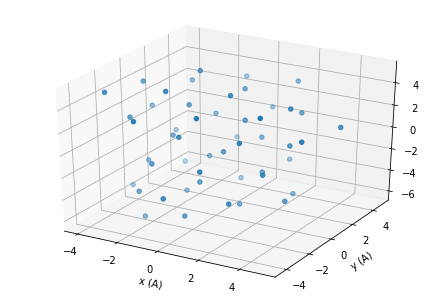

In [ ]:
fig1 = plt.figure()
plt.title('Muestra - Estado Final')
ax = Axes3D(fig1)
ax.scatter3D(r[:, 0] / 1e-10, r[:, 1] / 1e-10, r[:, 2] / 1e-10, 'or')
plt.xlabel('x (A)')
plt.ylabel('y (A)')
plt.savefig(plots + 'Muestra - Estado final.jpg')

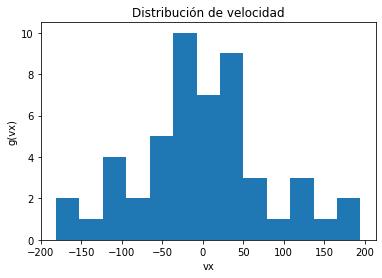

In [ ]:
# Histograma de distribución normal Vx
fig2 = plt.hist(MInitialState[:, 3], 13)
plt.ylabel('g(vx)')
plt.xlabel('vx')
plt.title('Distribución de velocidad')
plt.savefig(plots + 'Histograma de distribución normal Vx.jpg')

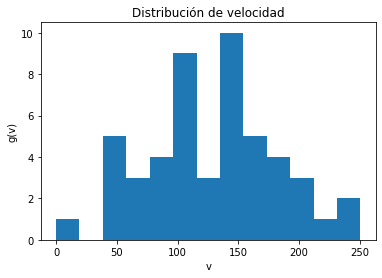

In [ ]:
# Histograma de distribución lognormal v magnitud
fig3 = plt.hist(MInitialState[:, 6], 13)
plt.ylabel('g(v)')
plt.xlabel('v')
plt.title('Distribución de velocidad')
plt.savefig(plots + 'Histograma de distribución lognormal v magnitud.jpg')

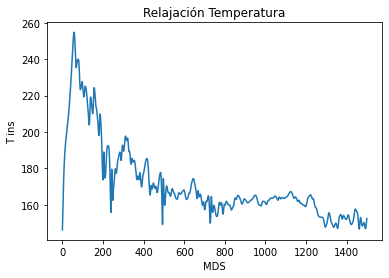

In [ ]:
x = np.arange(MDSMax)
fig4 = plt.plot(x,MRelaxation[:, 0])
plt.xlabel('MDS')
plt.ylabel('T ins')
plt.title('Relajación Temperatura')
plt.savefig(plots + 'Relajación Temperatura.jpg')

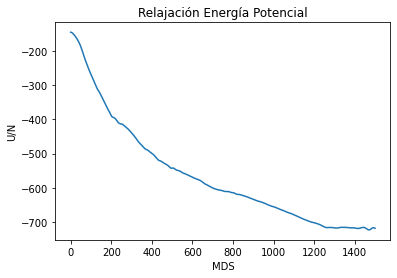

In [ ]:
fig5 = plt.plot(x,MRelaxation[:, 3])
plt.xlabel('MDS')
plt.ylabel('U/N')
plt.title('Relajación Energía Potencial')
plt.savefig(plots + 'Relajación Energía Potencial.jpg')

###Visualización resultados evolución - Variables vs TRA - Estado Final

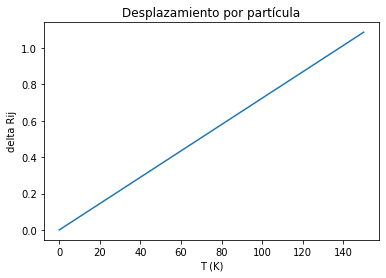

In [ ]:
fig1 = plt.plot(MResultsT[:, 0], MResultsT[:, 2])
plt.xlabel('T (K)')
plt.ylabel('delta Rij')
plt.title('Desplazamiento por partícula')
plt.savefig(plots + 'Desplazamiento por partícula.jpg')

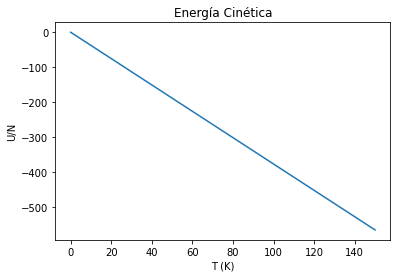

In [ ]:
fig2 = plt.plot(MResultsT[:, 0], MResultsT[:, 3])
plt.xlabel('T (K)')
plt.ylabel('U/N')
plt.title('Energía Cinética')
plt.savefig(plots + 'Energía Cinética.jpg')

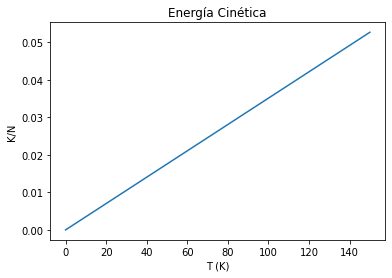

In [ ]:
fig3 = plt.plot(MResultsT[:,0 ], MResultsT[:, 4])
plt.xlabel('T (K)')
plt.ylabel('K/N')
plt.title('Energía Cinética')
plt.savefig(plots + 'Energía Cinética 2.jpg')

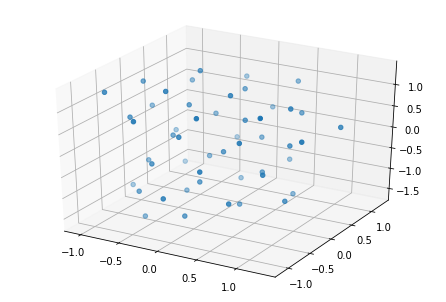

In [ ]:
fig4 = plt.figure()
plt.title('Estado final')
ax = Axes3D(fig4)
ax.scatter3D(r[:, 0] / ao, r[:, 1] / ao, r[:, 2] / ao, 'or')
plt.savefig(plots + 'Estado final.jpg')